Download dataset

In [ ]:
# This code downloads the coco dataset from Amazon S3 in parallel.
!pip install boto3
import boto3
from botocore import UNSIGNED
from botocore.client import Config
import multiprocessing
import subprocess
# Skipping large dataset for now
files = ['val2017.zip', 'annotations_trainval2017.zip'] #, 'train2017.zip']

s3 = boto3.client('s3', config=Config(signature_version=UNSIGNED))
def download_and_unzip_from_s3(file_name, bucket_name='fast-ai-coco'):
    print("Downloading", file_name)
    s3.download_file(bucket_name, file_name, file_name)
    print("Finished downloading", file_name, ". Starting to unzip.")
    subprocess.run(["unzip", file_name])
    print("Finished unzipping", file_name)

# Download in parallel
num_cpus = multiprocessing.cpu_count()
with multiprocessing.Pool(num_cpus) as p:
    p.map(download_and_unzip_from_s3, files)

print("Done transferring all datasets")



     |████████████████████████████████| 131 kB 5.2 MB/s 
     |████████████████████████████████| 79 kB 3.4 MB/s 
     |████████████████████████████████| 7.8 MB 36.3 MB/s 
     |████████████████████████████████| 138 kB 56.2 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
requests 2.23.0 requires urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you have urllib3 1.26.6 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
Finished downloading annotations_trainval2017.zip . Starting to unzip.
Finished downloading val2017.zip . Starting to unzip.
Finished unzipping annotations_trainval2017.zip
Finished unzipping val2017.zip
Done transferring all da

Define some functions

In [ ]:
from typing import List
from PIL import Image, ImageDraw


def return_cropped_and_resized_images(image):
    image_as_tensor = transform_image(image)
    classification = classify_image(image_as_tensor)
    valid_prediction_boxes = get_predictions_above_threshold(classification)

    return [(box, image.crop(box).resize((256, 192))) for box in valid_prediction_boxes]


def get_predictions_above_threshold(classification):
    predictions = []

    for prediction in classification:
        count = -1
        for label in prediction["labels"]:
            count += 1
            if label.item() != 1:
                continue

            if prediction["scores"][count].item() < 0.9:
                continue

            predictions.append(prediction["boxes"][count].tolist())

    return predictions


def load_image(image_id) -> Image:
    leading_zeros = "0" * (12 - len(str(image_id)))
    image_file = f"val2017/{leading_zeros}{image_id}.jpg"
    training_image = plt.imread(image_file)

    return Image.open(image_file)


def classify_image(image_as_tensor):
    model.eval()
    output = model([image_as_tensor])
    model.train()
    return output


def transform_image(image):
    # This transformation scales the pixel values to be in the [0, 1] range
    transform = torchvision.transforms.ToTensor()
    return transform(image)
    

In [ ]:
import torchvision.models.detection

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


Run model on some person images and show the boxes where it thinks a person is located. The cutoff for which boxes to show is set to 0.9

Box:  [74.31413269042969, 224.88836669921875, 342.2668762207031, 578.7736206054688]


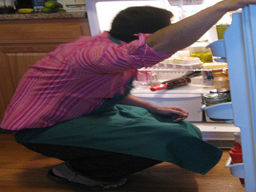

Box:  [492.5956115722656, 184.78077697753906, 527.38818359375, 253.179443359375]


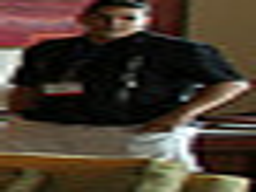

Box:  [40.558570861816406, 1.0979429483413696, 74.83658599853516, 54.86589050292969]


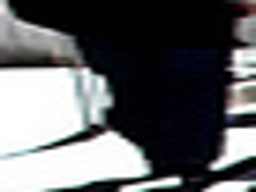

Box:  [62.42641830444336, 16.00202751159668, 285.4106140136719, 402.85516357421875]


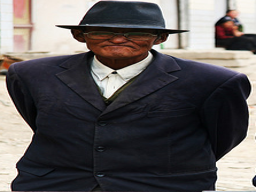

Box:  [273.45343017578125, 6.633858680725098, 516.97900390625, 414.5037536621094]


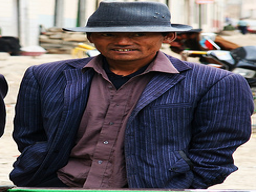

Box:  [498.6169738769531, 45.42489242553711, 510.61700439453125, 81.16974639892578]


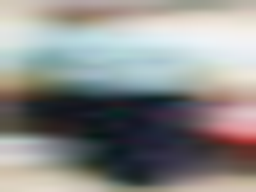

Box:  [620.548095703125, 49.81438064575195, 639.6871948242188, 132.85232543945312]


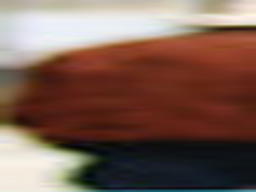

Box:  [249.02264404296875, 37.61762619018555, 295.6894226074219, 123.88545227050781]


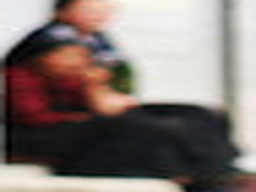

Box:  [102.76148223876953, 188.0440216064453, 124.21139526367188, 210.98316955566406]


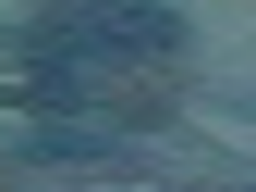

In [26]:
import json
from IPython.display import display


with open("annotations/instances_val2017.json") as annotations:
    annotations_data = json.load(annotations)

count = 0
for image_annotation in annotations_data["annotations"]:
  category_id = image_annotation["category_id"]

  # Category 1 is person
  if category_id != 1:
    continue

  image_id = image_annotation["image_id"]
  image = load_image(image_id)
  person_box_images = return_cropped_and_resized_images(image)

  for box, box_image in person_box_images:
    print("Box: ", box)
    display(box_image)

  count += 1
  if count == 5:
    break
